In [1]:
from os.path import isfile, join
from os import listdir
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import ast


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter



PATH = "dataset/eea7"
devices = ['80:e6:50:1b:a7:80', 'f8:cf:c5:97:e0:9e', '44:91:60:d3:d6:94', 'ec:d0:9f:db:e8:1f']

In [2]:
# These are some functions that take the dataset of .txt files and transform them into something managable.
#
# That is, a dictionary keyed by the 4 mac addresses, containing lists of each trace (file) for each device.
#
# E.g. {'mac1':[trace1,trace2,...], 'mac2':[trace1,trace2,....], ...} 
#
#     where "trace1" is the list of these entries: {'time':_, 'loc_x':_, ....} found in a single file, pertaining 
#     only to that e.x. 'mac1' address.
#---------------------------------------------------------------------------------------------------------

# Parse the dataset
# Each file is a list of: 
# {'time': 1522970319.103242, 'loc_x': 261.0, 'loc_y': 170.4637331897293, 'rss': '-25', 'mac': '80:e6:50:1b:a7:80'}

def parseFiles(PATH):
    
    onlyfiles = [f for f in listdir(PATH) if isfile(join(PATH, f))]

    #Each file is a trace of the wifi rss's along one line of one of the three triangles
    linetraces = []

    for file in onlyfiles:
        if not(".txt" in file):
            continue
        with open(join(PATH, file)) as fp:
            temp = ast.literal_eval(fp.read())
            linetraces.append(temp)
    
    return(linetraces)
        

#Make a list of one dictionary per file, with the MAC's as keys to the list of trace-entries for that device
# {'mac1':[[trace1],[trace2],...]}
def sortByMac(linetraces):

    
    sortedTraces = []
    for trace in linetraces:
        sortedTraces.append({})
    for sortedTrace in sortedTraces:
        for macAddress in devices:
            sortedTrace[macAddress] = []
    


    # For filedata in list of parsed files
    for i, trace in enumerate(linetraces):

        for entry in trace:
            
            if not(entry['mac'] in devices):
                print("Unknown MAC address. We have a problem.")
                exit(1)
                
            sortedTraces[i][entry['mac']].append(entry)
            
    sortedTraces2 = {}
    for device in devices:
        sortedTraces2[device] = []
    for datafile in sortedTraces:
        for mac in datafile.keys():
            sortedTraces2[mac].append(datafile[mac])
            
    return(sortedTraces2)


In [3]:
sortedTraces = sortByMac(parseFiles(PATH))


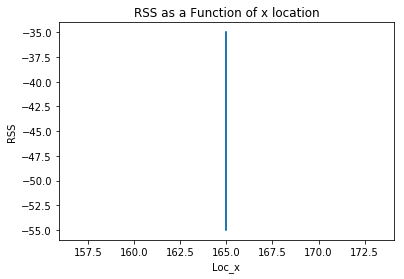

In [4]:
traces44 = sortedTraces['44:91:60:d3:d6:94']

rss = [float(entry['rss']) for entry in traces44[0]]
loc_x = [entry['loc_x'] for entry in traces44[0]]

plt.title("RSS as a Function of x location")
plt.xlabel("Loc_x")
plt.ylabel("RSS")

plt.plot(loc_x, rss)

In [5]:
def windowedAverage(values, windowSize):
    
    if len(values) == 0:
        return values
    
    paddedValues = []
    for i in range(windowSize//2):
        paddedValues.append(values[0])
    paddedValues = paddedValues + values
    for i in range(windowSize//2):
        paddedValues.append(values[-1])
    

    
    newList = []
    for i in range(len(values)):
        
        window = paddedValues[i:i+windowSize]

        newList.append(np.mean(window))

    
    return(newList)      

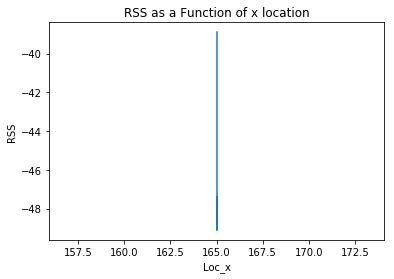

In [6]:
traces44 = sortedTraces['44:91:60:d3:d6:94']
k = 0

rss = [float(entry['rss']) for entry in traces44[k]]
loc_x = [entry['loc_x'] for entry in traces44[k]]
loc_y = [entry['loc_y'] for entry in traces44[k]]

rss = np.array(windowedAverage(rss, 20))
loc_x = np.array(windowedAverage(loc_x, 10))
loc_y = np.array(windowedAverage(loc_y, 10))

plt.title("RSS as a Function of x location")
plt.xlabel("Loc_x")
plt.ylabel("RSS")
plt.plot(loc_x, rss)

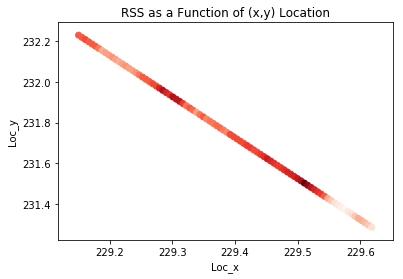

In [7]:
traces44 = sortedTraces['44:91:60:d3:d6:94']
k = 12

rss = [float(entry['rss']) for entry in traces44[k]]
loc_x = [entry['loc_x'] for entry in traces44[k]]
loc_y = [entry['loc_y'] for entry in traces44[k]]


rss = np.array(windowedAverage(rss, 7))
loc_x = np.array(windowedAverage(loc_x, 10000))
loc_y = np.array(windowedAverage(loc_y, 10000))


xx = np.ravel(loc_x)
yy = np.ravel(loc_y)
zz = np.ravel(rss)

plt.title("RSS as a Function of (x,y) Location")
plt.xlabel("Loc_x")
plt.ylabel("Loc_y")
plt.scatter(xx,yy,c=zz,cmap=cm.Reds)


In [8]:
#Let's see if we can map out the whole room for a single device's RSS signal

def getAllData(traces, rsswindow=1, locwindow=1):
    
    allData = [[],[],[]]
    
    #For each trace
    for i in range(len(traces)):
        rsss = [float(entry['rss']) for entry in traces44[i]]
        loc_xs = [entry['loc_x'] for entry in traces44[i]]
        loc_ys = [entry['loc_y'] for entry in traces44[i]]
        
        rss = windowedAverage(rsss, rsswindow)
        loc_x = windowedAverage(loc_xs, locwindow)
        loc_y = windowedAverage(loc_ys, locwindow)
        
        allData[0].append(loc_x)
        allData[1].append(loc_y)
        allData[2].append(rss)
    
    return(allData)

def catAllData(traces, rsswindow=1, locwindow=1):
    
    datatypes = getAllData(traces, rsswindow, locwindow)
    cattedData = [[],[],[]]
    
    
    for i, datatype in enumerate(datatypes):
        collector = []
        for trace in datatype:
            collector = collector + trace
        
        cattedData[i].append(np.array(collector))
    
    cattedData = np.array(cattedData)
    (x, y, z) = cattedData.shape
    cattedData = cattedData.reshape(x, z)
    
    return(cattedData)

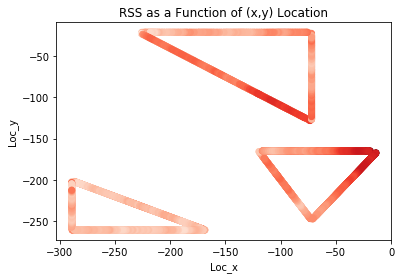

In [13]:
traces0 = sortedTraces[devices[0]]

allData = catAllData(traces0, rsswindow=10, locwindow=5)


plt.title("RSS as a Function of (x,y) Location")
plt.xlabel("Loc_x")
plt.ylabel("Loc_y")
plt.scatter(-allData[1],-allData[0],c=allData[2],cmap=cm.Reds)

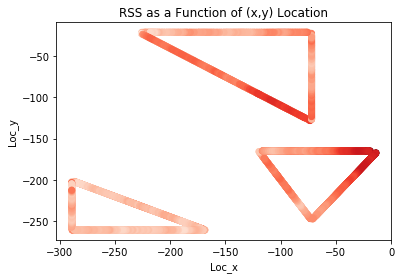

In [14]:
traces1 = sortedTraces[devices[1]]

allData = catAllData(traces1, rsswindow=10, locwindow=5)


plt.title("RSS as a Function of (x,y) Location")
plt.xlabel("Loc_x")
plt.ylabel("Loc_y")
plt.scatter(-allData[1],-allData[0],c=allData[2],cmap=cm.Reds)

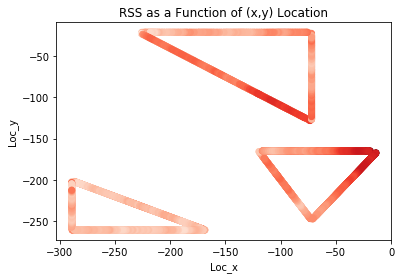

In [15]:
traces2 = sortedTraces[devices[2]]

allData = catAllData(traces2, rsswindow=10, locwindow=5)


plt.title("RSS as a Function of (x,y) Location")
plt.xlabel("Loc_x")
plt.ylabel("Loc_y")
plt.scatter(-allData[1],-allData[0],c=allData[2],cmap=cm.Reds)

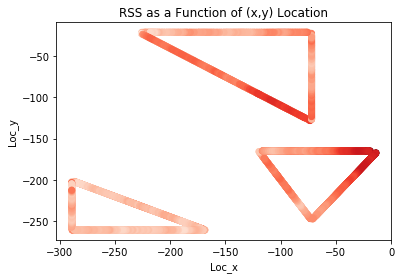

In [16]:
traces3 = sortedTraces[devices[3]]

allData = catAllData(traces3, rsswindow=10, locwindow=5)


plt.title("RSS as a Function of (x,y) Location")
plt.xlabel("Loc_x")
plt.ylabel("Loc_y")
plt.scatter(-allData[1],-allData[0],c=allData[2],cmap=cm.Reds)

In [11]:
# Now we should seperate the traces by leg of the triangle. So as to compare.
# We can then determine the correlation of the traces per leg, and prune those that deviate too far from it.

#Useful
def within(i, target, dev):

    if (np.abs(target - i) <= dev):
        return(True)
    else:
        return(False)


#Bin the traces associated with one MAC address by legs of the triangles.
def seperateByLeg(allTracesOfOneMac):
    
    bins = {"A1":[], "A2":[], "A3":[], "B1":[], "B2":[], "B3":[], "C1":[], "C2":[], "C3":[]}
    dev = 10

    
    for trace in allTracesOfOneMac:
        if len(trace) == 0:
            continue
        
        (x, y) = (trace[0]["loc_x"], trace[0]["loc_y"])

        if within(x, 249, dev) and within(y, 72, dev):
            bins["A1"].append(trace)

        elif within(x, 165, dev) and within(y, 120, dev):
            bins["A2"].append(trace)

        elif within(x, 165, dev) and within(y, 12, dev):
            bins["A3"].append(trace)

        elif within(x, 129, dev) and within(y, 72, dev):
            bins["B1"].append(trace)

        elif within(x, 21, dev) and within(y, 72, dev):
            bins["B2"].append(trace)

        elif within(x, 21, dev) and within(y, 228, dev):
            bins["B3"].append(trace)

        elif within(x, 261, dev) and within(y, 168, dev):
            bins["C1"].append(trace)

        elif within(x, 261, dev) and within(y, 289, dev):
            bins["C2"].append(trace)

        elif within(x, 201, dev) and within(y, 289, dev):
            bins["C3"].append(trace)

        else:
            #print("Oof: (" + str(x) + ", " + str(y) + ")")
            pass

    return(bins)
    

#Get a [m = len(tracesOfOneLegOfOneMac) x len(tracesOfOneLegOfOneMac)] matrix where m[i][j] = Corr(trace_i, trace_j) 
def getLegPairwiseSquareDiffs(allTracesOfOneLegOfOneMac):
    
    traces = allTracesOfOneLegOfOneMac
    
    avgSquareDiffMat = np.zeros((len(traces), len(traces)))
    
    for i in range(len(traces)):
        for j in range(len(traces)):
            
            if avgSquareDiffMat[j][i] != 0:
                avgSquareDiffMat[i][j] = avgSquareDiffMat[j][i]
                continue
            
            
            trace1 = traces[i]
            trace2 = traces[j]
            
            l1 = len(trace1)
            l2 = len(trace2)
            
            if l1 < l2:
                minL = l1
                maxL = l2
            else:
                minL = l2
                maxL = l1
            
            if (maxL/minL) > 1.5:
                #print("Woah these traces are way different in length. " + str(maxL) + " : " + str(minL))
                pass


                
            diffs = []
            for k in range(minL):
                rssDiff = np.sqrt((trace1[k]['rss'] - trace2[k]['rss'])**2)
                locXDiff = np.sqrt((trace1[k]['loc_x'] - trace2[k]['loc_x'])**2)
                locYDiff = np.sqrt((trace1[k]['loc_y'] - trace2[k]['loc_y'])**2)
                
                a = 1
                b = 0.01
                c = 0.01
                
                diffs.append(a*rssDiff + b*locXDiff + c*locYDiff)
            
            avg = np.mean(np.array(diffs))
            
            
            avgSquareDiffMat[i][j] = avg

    
    return(avgSquareDiffMat)

# Use the correlation matrix and some threshold to bin the leg traces into clusters
def binClusters(allTracesOfOneLegOfOneMac, squareDiffMat, maximumSquareDiff):
    
    diffMat = squareDiffMat
    traces = allTracesOfOneLegOfOneMac
                  
    clusters = []
    
    for i, trace in enumerate(traces):
        
        placed = False
        for k, cluster in enumerate(clusters):
            
            rejected = False
            for ctrace in cluster:
                
                ctraceNum = ctrace["id"]
                
                if diffMat[i][ctraceNum] == 0:
                    rejected = True
                    break
                
                if diffMat[i][ctraceNum] > maximumSquareDiff:
                    rejected = True
                    break
                    
            if not(rejected):
                clusters[k].append({"trace":trace, "id":i})
                placed = True
                break
        
        if not(placed):
            clusters.append([{"trace":trace, "id":i}])
    
                
    
    return(clusters)


def getClusterContainingPercentOfData(allTracesOfOneLegOfOneMac, squareDiffMat, percentTarget):
    
    traces = allTracesOfOneLegOfOneMac
    
    maxDiff = 0
    totalSize = len(traces)
    while(True):

        binnedClusters = binClusters(traces, squareDiffMat, maxDiff)
        
        largest = 0
        lSize = 0
        for i, cluster in enumerate(binnedClusters):
            size = len(cluster)
            
            if size >= lSize:
                largest = i
                lSize = size
        
        
        
        if lSize/totalSize >= percentTarget:
            break
        
        maxDiff += 0.2
    
    return (lSize, maxDiff, lSize/totalSize, binnedClusters[largest])


def tracesToTrace(traces):
    
    gigaTrace = []
    
    maxLen = 0
    t_id = 'r'
    for i in range(len(traces)):
        if len(traces[i]) >= maxLen:
            maxLen = len(traces[i])
            t_id = i
    
    
    for e in range(maxLen):
        entry = {'time':traces[t_id][i]["time"],'loc_x': [],'loc_y': [],'rss': [],'mac': traces[t_id][i]["mac"]}
        for t, trace in enumerate(traces):
            
            if len(trace) < maxLen:
                entry['loc_x'].append(float(traces[t_id][e]['loc_x']))
                entry['loc_y'].append(float(traces[t_id][e]['loc_y']))
                entry['rss'].append(float(traces[t_id][e]['rss']))
                continue
            
            entry['loc_x'].append(float(traces[t][e]['loc_x']))
            entry['loc_y'].append(float(traces[t][e]['loc_y']))
            entry['rss'].append(float(traces[t][e]['rss']))
        
        entry['loc_x'] = np.mean(entry['loc_x'])
        entry['loc_y'] = np.mean(entry['loc_y'])
        entry['rss'] = np.mean(entry['rss'])
        
        gigaTrace.append(entry)
    
    return(gigaTrace)
         
    
def clusterToTraces(cluster):
    traces = []
    for item in cluster:
        traces.append(item["trace"])
    return(traces)


def allTogetherNow(allTracesOfOneMac, percentTarget, rsswindow, locwindow):
    
    longLegs = seperateByLeg(allTracesOfOneMac)
    
    finalLegs = {"A1":[], "A2":[], "A3":[], "B1":[], "B2":[], "B3":[], "C1":[], "C2":[], "C3":[]}
    
    for key in longLegs.keys():
        legs = longLegs[key]
        diffMat = getLegPairwiseSquareDiffs(legs)
        size, diff, percent, cluster = getClusterContainingPercentOfData(legs, diffMat, percentTarget)
        
        finalLeg = tracesToTrace(clusterToTraces(cluster))
        
        
        if rsswindow > 1 or locwindow > 1:
            rsss = [float(entry['rss']) for entry in finalLeg]
            loc_xs = [entry['loc_x'] for entry in finalLeg]
            loc_ys = [entry['loc_y'] for entry in finalLeg]

            rss = windowedAverage(rsss, rsswindow)#[rsswindow//2:(-rsswindow//2)+1]
            loc_x = windowedAverage(loc_xs, locwindow)#[locwindow//2:(-locwindow//2)+1]
            loc_y = windowedAverage(loc_ys, locwindow)#[locwindow//2:(-locwindow//2)+1]

            for i in range(len(finalLeg)):
                finalLeg[i]["rss"] = rss[i]
                finalLeg[i]["loc_x"] = loc_x[i]
                finalLeg[i]["loc_y"] = loc_y[i]
            
        
        finalLegs[key] = finalLeg
    
    return(finalLegs)

# Now we can choose the largest or most correlated cluster, whatever works best, and throw out all the 
# other traces for that leg.

binned44 = seperateByLeg(traces44)
legA3 = binned44["A3"]
diffMat = getLegPairwiseSquareDiffs(legA3)


size, diff, percent, cluster = getClusterContainingPercentOfData(legA3, diffMat, 1)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [12]:
legs = allTogetherNow(sortedTraces[devices[1]], 0.3, rsswindow=50, locwindow=5)

processedTraces = []

for leg in legs.keys():
    processedTraces.append(legs[leg])

allData = catAllData(processedTraces, rsswindow=1, locwindow=1)


plt.title("RSS as a Function of (x,y) Location")
plt.xlabel("Loc_x")
plt.ylabel("Loc_y")
plt.scatter(-allData[1],-allData[0],c=allData[2],cmap=cm.Reds)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
devices = ['80:e6:50:1b:a7:80', 'f8:cf:c5:97:e0:9e', '44:91:60:d3:d6:94', 'ec:d0:9f:db:e8:1f']

legs80 = allTogetherNow(sortedTraces[devices[0]], 0.3, rsswindow=50, locwindow=5)
legsf8 = allTogetherNow(sortedTraces[devices[1]], 0.3, rsswindow=50, locwindow=5)
legs44 = allTogetherNow(sortedTraces[devices[2]], 0.3, rsswindow=50, locwindow=5)
legsec = allTogetherNow(sortedTraces[devices[3]], 0.3, rsswindow=50, locwindow=5)


print(legs80.keys())

In [ ]:
#Quick dist function for length between two points
def dist(x1, y1, x2, y2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2)

# Now we want to find P for our rss equation, so let's
# get an average of rss at a distance of ~1m from the AP
# The ground truth of this device is: (-22, 162) for '44:91:60:d3:d6:94'
t = seperateByLeg(traces44)
s = t["A3"]
r = s[0]
i = 0
tot = 0
for entry in r:
    d = 0.0254 * dist(entry["loc_y"], entry["loc_x"], -22, 162)
    if  (d<1.05 and d>0.95):
        i+=1
        tot += float(entry["rss"])
avg_rss = tot/i
avg_rss

In [ ]:
# Returns a distance in meters given rss
def rssToDistance(rss):
    gamma = 2.2 #From wikipedia for general open room
    P = (-37.6) #From above
    return 10**((P-rss)/(10*gamma)) #From mobicom paper @45 in piazza

def intersect(c1, c2, c3):
    x0 = c1["loc_y"]
    y0 = c1["loc_x"]
    r0 = 39.3701*rssToDistance(float(c1["rss"]))
    x1 = c2["loc_y"]
    y1 = c2["loc_x"]
    r1 = 39.3701*rssToDistance(float(c2["rss"]))
    x2 = c3["loc_y"]
    y2 = c3["loc_x"]
    r2 = 39.3701*rssToDistance(float(c3["rss"]))
    
    #Unfortunately, I couldn't get this to work in time for the deadline
    return (0,0)
    

In [ ]:
#Modified insertion sort I took from https://www.tutorialspoint.com/python/python_sorting_algorithms.htm
def sort_by_rss(entries):
    for i in range(1, len(entries)):
        j = i-1
        nxt_element = entries[i]

        while (float(entries[j]["rss"]) > float(nxt_element["rss"])) and (j >= 0):
            entries[j+1] = entries[j]
            j=j-1
        entries[j+1] = nxt_element
    return entries


# Returns the three entries with the highest rss that lie on three different traces
def find_top_entries(traces):
    max_entries = []
    for key in traces.keys():
        trace = traces[key][0]
        max_rss_entry = trace[0]
        for entry in trace:
            if float(entry["rss"]) > float(max_rss_entry["rss"]):
                max_rss_entry = entry
        max_entries.append(max_rss_entry)
    arr = sort_by_rss(max_entries)
    return arr[:3]

# change devices to 0-3 to get estimates for location
traces = seperateByLeg(sortedTraces[devices[3]])
arr = find_top_entries(traces)
answer = intersect(arr[0], arr[1], arr[2])
answer